<a href="https://colab.research.google.com/github/FelipeMoreira01/Machine-Learning-FCC/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2021-01-05 19:41:47--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘book-crossings.zip.9’

book-crossings.zip.     [              <=>   ]  24.88M  9.05MB/s    in 2.7s    

2021-01-05 19:41:50 (9.05 MB/s) - ‘book-crossings.zip.9’ saved [26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
# add your code here - consider creating a new cell for each section of code
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


Graph dataset to see how it look, books ISBN v/s frequency recomendation 

Text(0.5, 1.0, 'Rating frequency of all books')

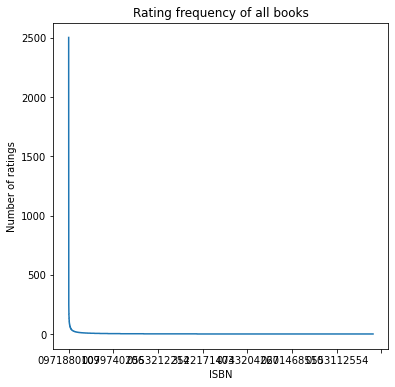

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
df_ratings['isbn'].value_counts().plot()
ax.set_xlabel("ISBN")
ax.set_ylabel("Number of ratings")
ax.set_title("Rating frequency of all books")

Filter dataset: remove users with less than 200 ratings and books with less than 100 ratings

In [ ]:
rating_count = df_ratings.groupby('isbn').count().reset_index().rename(columns={'rating':'ratingCount'})[['isbn','ratingCount']]
rating_count.head()

,isbn,ratingCount
0,0330299891,2
1,0375404120,2
2,0586045007,1
3,9022906116,2
4,9032803328,1


In [ ]:
user_count = df_ratings.groupby('user').count().reset_index().rename(columns={'rating':'userCount'})[['user','userCount']]
user_count.head()

,user,userCount
0,2,1
1,7,1
2,8,18
3,9,3
4,10,2


In [ ]:
df_merge = df_ratings.merge(rating_count, on='isbn', how='left')
df_merge = df_merge.merge(user_count, on='user', how='left')
df_merge.head()

,user,isbn,rating,ratingCount,userCount
0,276725,034545104X,0.0,60,1
1,276726,0155061224,5.0,2,1
2,276727,0446520802,0.0,116,1
3,276729,052165615X,3.0,1,2
4,276729,0521795028,6.0,1,2


In [ ]:
df_ratings_combined = df_merge.merge(df_books, left_on='isbn', right_on='isbn', how='left')
df_ratings_combined = df_ratings_combined.drop('author', axis=1)
df_ratings_combined.head()

,user,isbn,rating,ratingCount,userCount,title
0,276725,034545104X,0.0,60,1,Flesh Tones: A Novel
1,276726,0155061224,5.0,2,1,Rites of Passage
2,276727,0446520802,0.0,116,1,The Notebook
3,276729,052165615X,3.0,1,2,Help!: Level 1
4,276729,0521795028,6.0,1,2,The Amsterdam Connection : Level 4 (Cambridge ...


In [ ]:
user_min_rating = 200
book_min_rating = 100

df_ratings_combined.query('ratingCount >= @book_min_rating and userCount >= @user_min_rating', inplace=True)

df_ratings_combined[['ratingCount','userCount']].describe()

,ratingCount,userCount
count,49781.000000,49781.000000
mean,253.080914,1091.719833
std,250.261203,1770.426671
min,100.000000,200.000000
25%,133.000000,319.000000
50%,181.000000,552.000000
75%,284.000000,1172.000000
max,2502.000000,13602.000000


Now we have to transform the df to a proper format: m x n array where m is the number of book and n the number of users, then we convert it to a df scipy sparce matrix to give it to the model

In [ ]:
df_ratings_combined = df_ratings_combined.drop_duplicates(['title', 'user'])


pivot_df_ratings = df_ratings_combined.pivot(
    index='title', #m: numbers of books
    columns='user', #n: number of user
    values='rating'
).fillna(0)

#convert df to scipy sparse matrix
new_df = csr_matrix(pivot_df_ratings.values)

pivot_df_ratings.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,6543,6563,6575,7158,7286,7346,7915,8067,8245,8681,8936,9856,10447,10819,11601,11676,11993,12538,12824,12982,13082,13273,13552,13850,14422,14521,15408,15418,15957,16106,...,264317,264321,264637,265115,265313,265595,265889,266056,266226,266753,266865,266866,267635,268030,268032,268110,268330,268622,268932,269566,269719,269728,269890,270713,270820,271195,271284,271448,271705,273979,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NaN,8.0,0.0,0.0,0.0,0.0,9.0,0.0,3.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Configure KNN model

In [ ]:
model = NearestNeighbors(metric='cosine',
                         algorithm='brute')
model.fit(new_df)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    recommended_books = []
    recommended_books.append(book)

    distances, indices = model.kneighbors(pivot_df_ratings.loc[book].values.reshape(1, -1), n_neighbors= 5)
    
    aux = []

    for i in range(1,len(distances.flatten())):
        aux1 = []
        aux1.append(pivot_df_ratings.iloc[indices.flatten()[-i]].name)
        aux1.append(round(distances.flatten()[-i],2))
        aux.append(aux1)

    recommended_books.append(aux)        

    return recommended_books

['The Queen of the Damned (Vampire Chronicles (Paperback))', [['The Witching Hour (Lives of the Mayfair Witches)', 0.74], ['Interview with the Vampire', 0.73], ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.54], ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.52]]]


Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Weight of Water', 0.77], ['The Surgeon', 0.77], ['I Know This Much Is True', 0.77], ['The Lovely Bones: A Novel', 0.72]]]
You passed the challenge! 🎉🎉🎉🎉🎉
